<a href="https://colab.research.google.com/github/EliseuODaniel/Analise_temperatura_motor_eletrico/blob/main/analise_3_Polynomial_Regressionl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Polynomial Regression

In [110]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import os

In [111]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/notebooks/input/measures_v2.csv')
df.shape

(1330816, 13)

In [112]:
from sklearn.preprocessing import PolynomialFeatures

In [113]:
# remoção da coluna torque, pois não servirá como variável nem de entrada e nem de saída
df.drop('torque', axis=1, inplace=True)

#Separação entre Datasets de treino e de teste

In [348]:
#testagens separadas pra teste
test_set_profiles = range(65,73)
x_cols = ['ambient', 'coolant','i_q', 'u_q','i_d', 'u_d', 'motor_speed'] #RMSE = 10.51 (com todas as variáveis)
#x_cols = ['ambient', 'coolant','i_q', 'u_q','i_d', 'u_d'] #RMSE = 12.06 (sem motor_speed)
#x_cols = ['ambient', 'coolant','i_q', 'u_q','i_d',  'motor_speed'] #RMSE =  10.55
#x_cols = ['ambient', 'coolant','i_q', 'u_q', 'u_d', 'motor_speed'] #RMSE = 11.79
#x_cols = ['ambient', 'coolant','i_q', 'i_d', 'u_d', 'motor_speed'] #RMSE = 12.22
#x_cols = ['ambient', 'coolant', 'u_q','i_d', 'u_d', 'motor_speed'] #RMSE = 10.36 (sem i_q - melhor resultado)
#x_cols = ['ambient', 'i_q', 'u_q','i_d', 'u_d', 'motor_speed'] #RMSE = 11.38
#x_cols = [ 'coolant','i_q', 'u_q','i_d', 'u_d', 'motor_speed'] #RMSE = 11.01

#separado 2 datasets, um com as testagens que serão usadas pra treino e outro as de teste
trainset = df.loc[~df.profile_id.isin(test_set_profiles), :].reset_index(drop=True)
testset = df.loc[df.profile_id.isin(test_set_profiles), :].reset_index(drop=True)


X_train = trainset.loc[:, x_cols]
y_train = trainset.loc[:, 'pm']
X_test = testset.loc[:, x_cols]
y_test = testset.loc[:, 'pm']

a variável motor_speed cria resíduos distantes da média, como outliers. Talvez pela unidade da medida de velocidade.

In [349]:
X_train.shape

(1148796, 6)

In [350]:
X_test.shape

(182020, 6)

# Modelagem

In [351]:
polynomial_converter = PolynomialFeatures(degree=2,include_bias=False)

In [352]:
# Converter "fits" to data, in this case, reads in every X column
# Then it "transforms" and ouputs the new polynomial data
X_train_poly_features = polynomial_converter.fit_transform(X_train)
X_test_poly_features = polynomial_converter.fit_transform(X_test)

In [353]:
X_train_poly_features.shape

(1148796, 27)

In [354]:
X_test_poly_features.shape

(182020, 27)

In [355]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_poly_features,y_train)
test_predictions = model.predict(X_test_poly_features)

# Mensuração dos erros

In [356]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [357]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [358]:
MAE

8.185612385888744

In [359]:
MSE

111.51085399422324

In [360]:
RMSE

10.55986997998665

In [361]:
#valor médio das temperaturas do rotor em todo o dataset - para comparar com o RMSE
#ou seja, as previsões do modelo variam 12 para + e - de 58,51
df['pm'].mean()

58.50677585061459

Comparison with multiple linear regression  
MAE = 9.626260043968127  
MSE = 145.61949126832434   
RMSE = 12.067290137736986 

In [362]:
model.coef_

array([-9.36056095e+00,  1.50932618e+00,  1.33080018e-01, -1.73857185e+00,
        6.44506583e-03,  1.21266433e-01,  3.32099419e-01, -4.38291065e-02,
       -3.19786935e-03, -1.95485219e-02,  1.18960068e-03, -5.02681433e-04,
       -1.60145070e-03, -3.74151248e-04,  3.98308487e-03, -1.34661917e-03,
       -1.62532306e-04,  2.35370955e-04,  4.00675748e-04, -2.79401440e-04,
        6.76086629e-08, -2.82867779e-03,  4.86934532e-03,  2.26403306e-04,
       -1.13875395e-03,  2.71732550e-04, -5.30895921e-06])

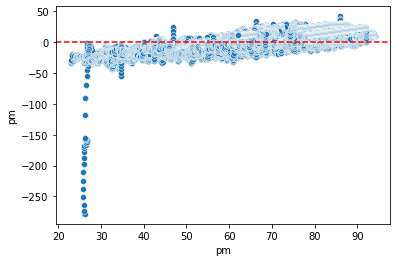

In [363]:
# plotagem da distribuição dos resíduos
test_res = y_test - test_predictions

sns.scatterplot(x=y_test,y=test_res)
plt.axhline(y=0, color='r', linestyle='--')

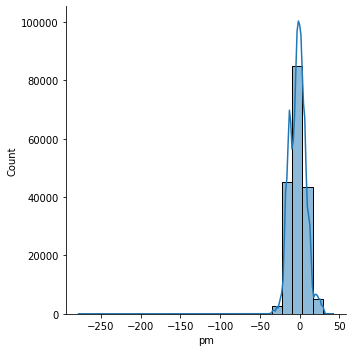

In [364]:
#plotagem da distribuição dos resíduos pra verificar visualmente a normalidade
sns.displot(test_res,bins=25,kde=True)

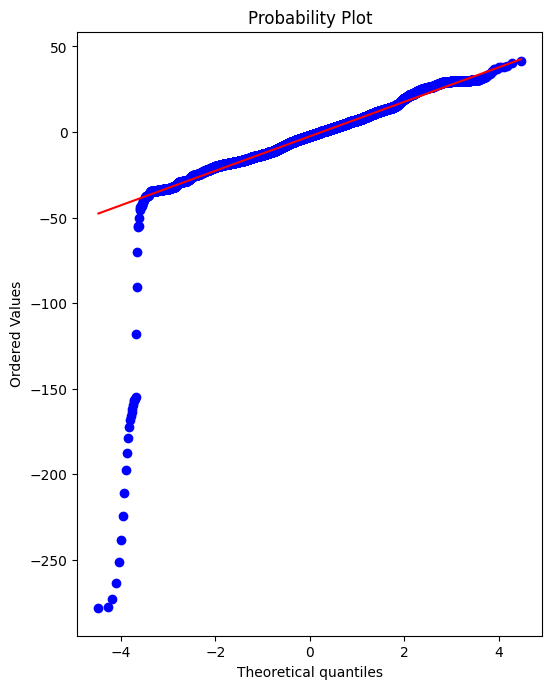

In [365]:
import scipy as sp
# Create a figure and axis to plot on
fig, ax = plt.subplots(figsize=(6,8),dpi=100)
# probplot returns the raw values if needed
# we just want to see the plot, so we assign these values to _
_ = sp.stats.probplot(test_res,plot=ax)